### Created on 2023
### @author: S.W

In [25]:
# =============================================================================
# # git download
# # https://git-scm.com/downloads
# =============================================================================

In [2]:
# !pip install tensorflow_datasets
# !git clone https://github.com/tensorflow/examples.git

## 1. 학습에 필요한 라이브러리 불러오기

In [3]:
import tensorflow as tf
import tensorflow.keras as keras

from examples.tensorflow_examples.models.pix2pix import pix2pix
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

### Oxford-IIIT Pets 데이터 세트

- 데이터셋은 이미 텐서플로 데이터 세트에 포함
- 이 데이터 세트에는 총 7,349장의 이미지가 포함되어 있으며, 37개 종의 개와 고양이 품종에 대한 데이터로 구성
- 훈련 세트에는 약 6,000장의 이미지가 포함
- 테스트 세트에는 약 1,349장의 이미지가 포함
- 이미지 크기는 일정하지 않음
- 일반적으로 이미지 크기를 224x224 픽셀 또는 299x299 픽셀로 조정하여 학습 및 평가에 사용

#### 데이터셋 목록
- https://www.tensorflow.org/datasets/catalog/overview?hl=ko

####  Oxford-IIIT Pets tensorflow 공식 documents
- https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet?hl=ko

In [26]:
import tensorflow_datasets as tfds

dataset, dataset_info = tfds.load('oxford_iiit_pet', with_info=True, split=['train', 'test'])

In [31]:
dataset

[<PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>,
 <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>]

dataset_info 변수는 데이터 세트에 대한 메타 정보를 포함하며, 이를 통해 이미지의 수, 품종의 수, 데이터 세트의 전체 크기 등의 정보를 얻을 수 있습니다.

In [32]:
dataset_info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='C:\\Users\\sangwoo\\tensorflow_datasets\\oxford_iiit_pet\\3.2.0',
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
 

In [41]:
dataset[0].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)

<ParallelMapDataset shapes: ((128, 128, 3), (128, 128, 1)), types: (tf.float32, tf.float32)>

In [58]:
info.splits.keys(), info.splits['train'].num_examples, info.splits['test'].num_examples

(dict_keys(['train', 'test']), 3680, 3669)

## 2. 이미지 전처리

In [59]:
def normalize(input_image, input_mask):
    # 0~1 표준화
    input_image = tf.cast(input_image, tf.float32) / 255.0
    # 해당 데이터셋의 마스크는 객체의 경우1~3 사이의 값을 가짐. 따라서 -1을 함으로써 0~2로 바뀜.
    # 배경의 경우 0의 값을 가지며, 띠라서 -1로 바뀜
    input_mask -= 1 
    return input_image, input_mask


@tf.function
def load_image_train(datapoint):
    # 학습 이미지 전처리
    # 원본 이미지와 마스크 데이터를 128x128 픽셀 크기로 조정
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    # 확률적으로 이미지와 마스크 데이터를 좌우 반전. 이를 통해 데이터의 다양성을 높이고 과적합을 방지
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    # 이미지와 마스크 데이터를 정규화.
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask


def load_image_test(datapoint):
    # 테스트 이미지 전처리
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [6]:
# 학습 데이터의 총 개수
TRAIN_LENGTH = info.splits['train'].num_examples  # 3680
BATCH_SIZE = 64 # 배치 크기를 설정
BUFFER_SIZE = 1000 # 데이터셋 셔플링에 사용할 버퍼 크기를 설정
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE # 에폭당 스텝 수

# 학습 데이터셋에 load_image_train 함수를 적용하여 이미지 전처리를 수행
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# 테스트 데이터셋에 load_image_test 함수를 적용하여 이미지 전처리를 수행
test = dataset['test'].map(load_image_test)

# 학습 데이터셋을 캐싱하고, 버퍼 크기로 셔플한 후, 배치 크기로 나누고, 데이터를 반복
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# 학습 데이터셋의 성능을 향상시키기 위해 프리페치를 사용
# 프리페치: 모델 학습 중에 GPU나 CPU가 다음 데이터를 기다리지 않도록, 데이터를 미리 메모리에 준비
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# 테스트 데이터셋을 배치 크기로 나눔
test_dataset = test.batch(BATCH_SIZE)

### 이미지 시각화

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    
    # 각각의 이미지에 대한 제목을 지정
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    # display_list에 있는 이미지를 순회하며 시각화
    for i in range(len(display_list)):
        # 1행 x display_list 개수의 열로 구성된 서브플롯을 생성
        plt.subplot(1, len(display_list), i + 1)
        
        plt.title(title[i]) # 해당 이미지의 제목을 설정
        plt.imshow(display_list[i]) # 이미지를 출력
        plt.axis('off') # 이미지의 축 정보를 숨김
    plt.show()

# 학습 데이터셋에서 하나의 이미지와 마스크 데이터를 가져옴
for image, mask in train.take(1):
    print(image.shape)
    print(mask.shape)
    sample_image, sample_mask = image, mask

AxesImage(80,52.8;496x369.6)


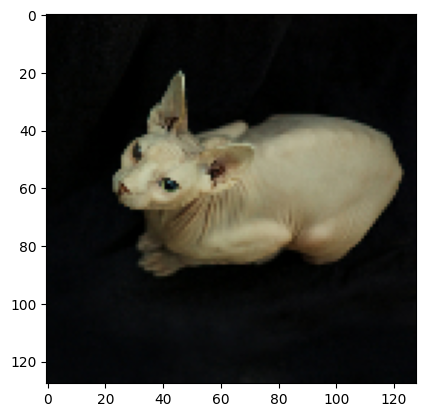

In [72]:
# 가져온 이미지를 출력
print(plt.imshow(sample_image))

AxesImage(80,52.8;496x369.6)


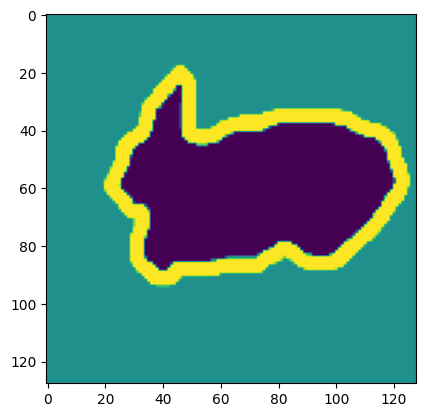

In [73]:
# 가져온 마스크 데이터를 출력
print(plt.imshow(sample_mask))

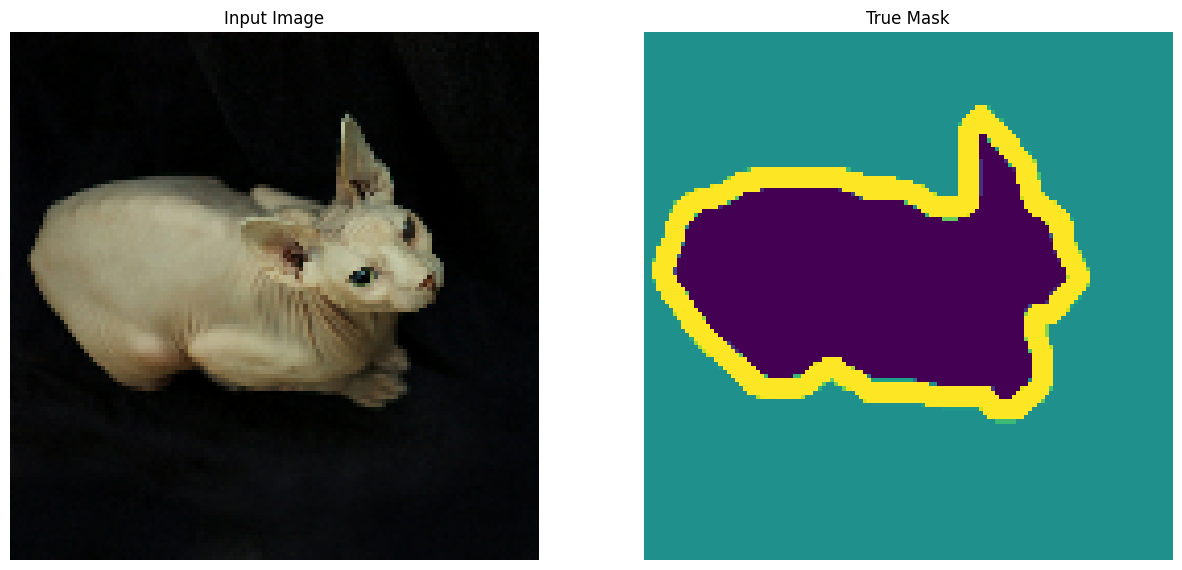

In [63]:
display([sample_image, sample_mask])

## 3. 모델 학습

#### 모델 정의 : U-Net 사용
- U-Net은 인코더(다운샘플러)와 디코더(업샘플러)를 포함
- 강력한 기능을 학습하고 훈련 가능한 매개변수의 수를 줄이기 위해 미리 훈련된 모델을 인코더로 사용 가능

- 인코더는 미리 훈련된 MobileNetV2 모델 사용 이 모델의 중간 출력이 사용
- 디코더는 Pix2pix 튜토리얼의 TensorFlow 예제에서 이미 구현된 업샘플 블록 사용

- 3개의 채널을 출력하는 이유는 픽셀당 3개의 가능한 라벨이 있기 때문
- 각 화소가 세 개의 class로 분류되는 다중 분류


In [74]:
OUTPUT_CHANNELS=3


#### 인코더 모델 : MobileNetV2

- tf.keras.applications 사용
- 인코더는 모델의 중간 층에서 나오는 특정 출력으로 구성
- 인코더는 학습 과정 중에 가중치가 추가로 학습되지 않는다는 점에 유의(trainable=False)

In [76]:
base_model= tf.keras.applications.MobileNetV2(input_shape=[128,128,3],
                                   include_top=False) # 출력층 제외

dir(base_model)  
base_model.summary() 
base_model.layers[1].name
base_model.layers[1].output

layer_list=[base_model.layers[i].name for i in range(len(base_model.layers))]   

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [77]:
# 이 층들의 활성화 이용
layer_names=[
    'block_1_expand_relu', # 64x64
    'block_3_expand_relu', # 32x32
    'block_6_expand_relu', # 16x16
    'block_13_expand_relu', # 8x8
    'block_16_project']  # 4x4

layers=[base_model.get_layer(name).output for name in layer_names]

In [78]:
layers

[<KerasTensor: shape=(None, 64, 64, 96) dtype=float32 (created by layer 'block_1_expand_relu')>,
 <KerasTensor: shape=(None, 32, 32, 144) dtype=float32 (created by layer 'block_3_expand_relu')>,
 <KerasTensor: shape=(None, 16, 16, 192) dtype=float32 (created by layer 'block_6_expand_relu')>,
 <KerasTensor: shape=(None, 8, 8, 576) dtype=float32 (created by layer 'block_13_expand_relu')>,
 <KerasTensor: shape=(None, 4, 4, 320) dtype=float32 (created by layer 'block_16_project')>]

#### 추출한 층으로 모델 구성

In [80]:
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
# model freeze
down_stack.trainable=True

#### 디코더/업샘플러
- TensorFlow 예제에서 구현된 일련의 업샘플 블록
- pix2pix에서 정의한 upsampling 함수 불러오기

In [81]:
up_stack=[
    pix2pix.upsample(512,3), # 4x4 -> 8x8
    pix2pix.upsample(256,3), # 8x8 -> 16x16
    pix2pix.upsample(128,3), # 16x16 -> 32x32
    pix2pix.upsample(64,3)]  # 32x32 -> 64x64

### unet_model 함수 정의

In [82]:
def unet_model(output_channels):
    inputs = tf.keras.Input(shape=[128, 128, 3])  # 이미지의 크기는 128x128x3
    x = inputs

    # 다운샘플링 과정을 수행
    skips = down_stack(x)
    x = skips[-1]
    # skip 연결을 위해 마지막 요소를 제외한 나머지 요소들을 뒤집습니다.
    skips = reversed(skips[:-1])

    # skip 연결을 포함하는 업샘플링 과정을 수행합니다.
    for up, skip in zip(up_stack, skips):
        x = up(x)
        # 건너뛰기(skip) 연결을 위해 Concatenate 레이어를 사용합니다.
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # 모델의 마지막 층을 설정.
    # 2D 전치 합성곱 레이어를 사용하여 마스크의 크기를 64x64에서 128x128로 확장
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  # 64x64 -> 128x128

    x = last(x)

    # 입력과 출력을 포함하는 모델을 반환합니다.
    return tf.keras.Model(inputs=inputs, outputs=x)


### 모델 학습/훈련
- 손실 함수는 loss.sparse_categorical_crossentropy 사용
- 이 손실 함수를 사용하는 이유는 네트워크가 멀티 클래스 예측과 마찬가지로  픽셀마다 레이블을 할당 하기 때문
- 실제 분할 마스크에서 각 픽셀은 {0,1,2}를 가지고 있음
- 이곳의 네트워크는 세 개의 채널을 출력하고 있음
- 기본적으로 각 채널은 클래스를 예측하는 방법을 배우려고 하고 있으며, loss.sparse_categical_crossentropy는 그러한 시나리오에 권장되는 손실함수
- 네트워크의 출력을 사용하여 픽셀에 할당된 레이블은 가장 높은 값을 가진 채널로 출력
- 이것이 create_mask 함수가 하는 일

In [84]:
model=unet_model(OUTPUT_CHANNELS)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_3 (Functional)            [(None, 64, 64, 96), 1841984     input_6[0][0]                    
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 8, 8, 512)    1476608     model_3[1][4]                    
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 8, 8, 1088)   0           sequential_4[1][0]               
                                                                 model_3[1][3]              

In [85]:
model.compile(optimizer='adam',
              # from_logits : output의 값이 확률이 아닌 상수임
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['acc'])

#### 마스크 생성 함수 정의
-  입력으로 받은 예측된 세그멘테이션 마스크에서 각 픽셀의 최종 라벨을 결정

In [17]:
def create_mask(pred_mask):
    # 예측된 마스크에서 각 픽셀에 대해 가장 높은 확률 값을 가진 라벨의 인덱스를 선택
    pred_mask = tf.argmax(pred_mask, axis=-1)
    # 선택한 인덱스를 마지막 축에 추가하여 새로운 차원 생성
    pred_mask = pred_mask[..., tf.newaxis]
    # 배치의 첫 번째 이미지에 대한 마스크만 반환
    return pred_mask[0]

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


####  학습전 모델 예측 마스크이미지시각화

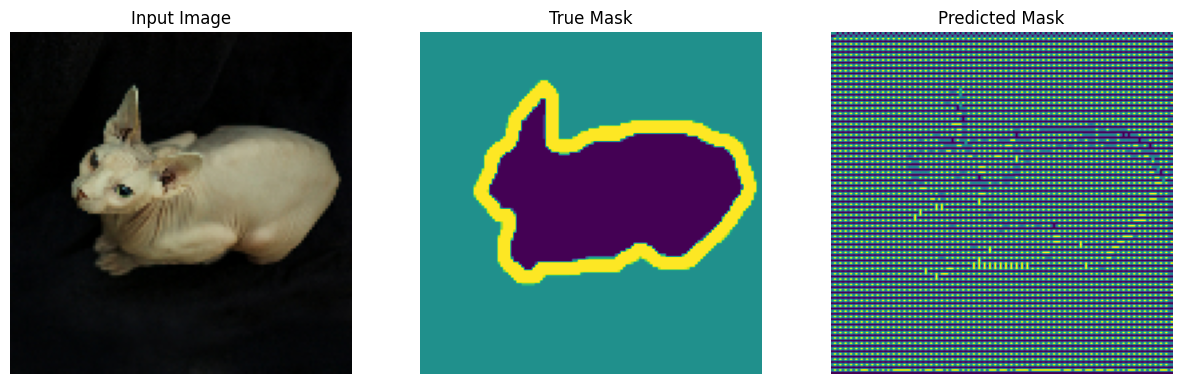

In [89]:
def show_predictions(dataset=None, num=1):
    # 데이터셋이 주어진 경우
    if dataset:
        # 데이터셋에서 'num' 개의 샘플을 가져옴
        for image, mask in dataset.take(num):
            # 각 이미지에 대해 모델을 사용하여 세그멘테이션 마스크를 예측
            pred_mask = model.predict(image)
            # 입력 이미지, 실제 마스크, 예측된 마스크를 시각화
            display([image[0], mask[0], create_mask(pred_mask)])
    # 데이터셋이 주어지지 않은 경우
    else:
        # 기존에 저장된 샘플 이미지와 마스크를 사용하여 예측을 시각화
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

# 예측 결과를 시각화합니다.
show_predictions()

#### 모델 학습 시에 epoch이 끝날 때 예측 결과를 시각화 하는 사용자 콜백 함수 정의

In [92]:
class DisplayCallback(tf.keras.callbacks.Callback):
    # 각 에포크가 종료될 때 호출되는 메서드를 정의
    def on_epoch_end(self, epoch, logs=None):
        # 출력을 지우고 현재 예측 결과를 화면에 유지
        clear_output(wait=True)
        # 샘플 이미지에 대한 예측 결과를 시각화
        show_predictions()
        # 현재 에포크 번호를 출력
        print('\n에포크 이후 예측 예시 {}\n'.format(epoch+1))

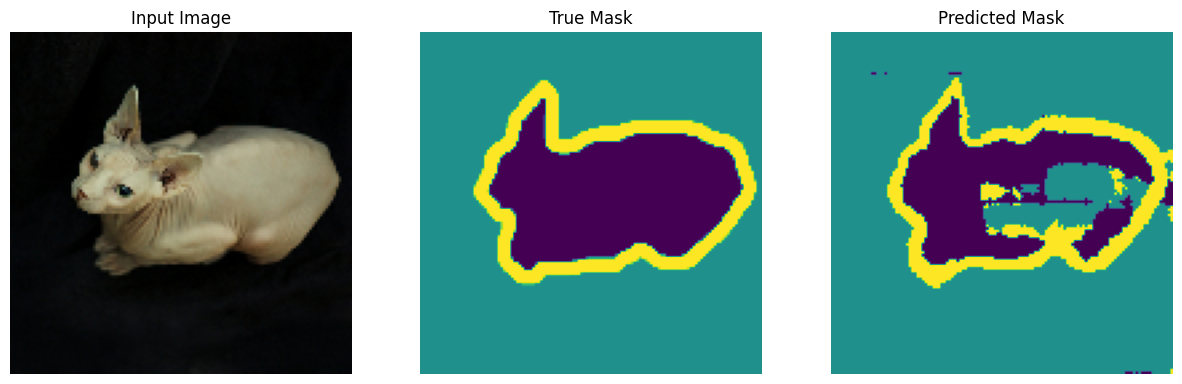


에포크 이후 예측 예시 20



In [93]:
# 파라미터 설정

EPOCHS = 20  # 에포크 수
VAL_SUBSPLITS = 5  # 검증 데이터셋의 서브 샘플 수
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS  # 검증 스텝 수

# 모델 학습
model_history = model.fit(
    train_dataset,  # 학습 데이터셋
    epochs=EPOCHS,  # 총 에포크 수
    steps_per_epoch=STEPS_PER_EPOCH,  # 에포크 당 스텝 수
    validation_steps=VALIDATION_STEPS,  # 검증 단계 수
    validation_data=test_dataset,  # 검증 데이터셋
    callbacks=[DisplayCallback()]  # 사용자 정의 콜백 클래스를 전달하여 학습 중 시각화를 수행
)


#### 학습 과정 시각화

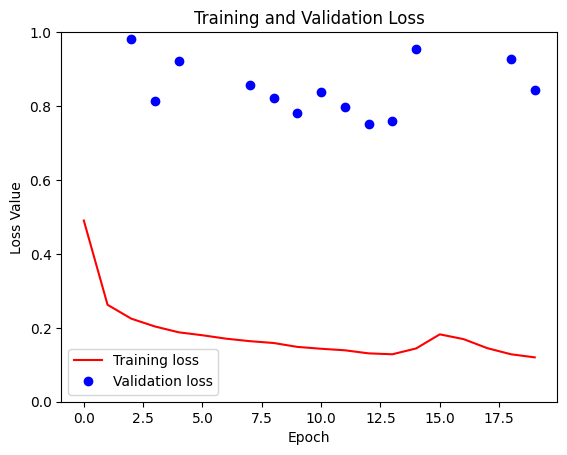

In [94]:
loss = model_history.history['loss']  
val_loss = model_history.history['val_loss']  

epochs = range(EPOCHS)  

plt.figure()  
plt.plot(epochs, loss, 'r', label='Training loss')  # 학습 손실 그래프
plt.plot(epochs, val_loss, 'bo', label='Validation loss')  # 검증 손실 그래프
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')  # x축 레이블
plt.ylabel('Loss Value')  # y축 레이블
plt.ylim([0, 1])  # y축 범위 설정
plt.legend()  # 범례 표시
plt.show() 

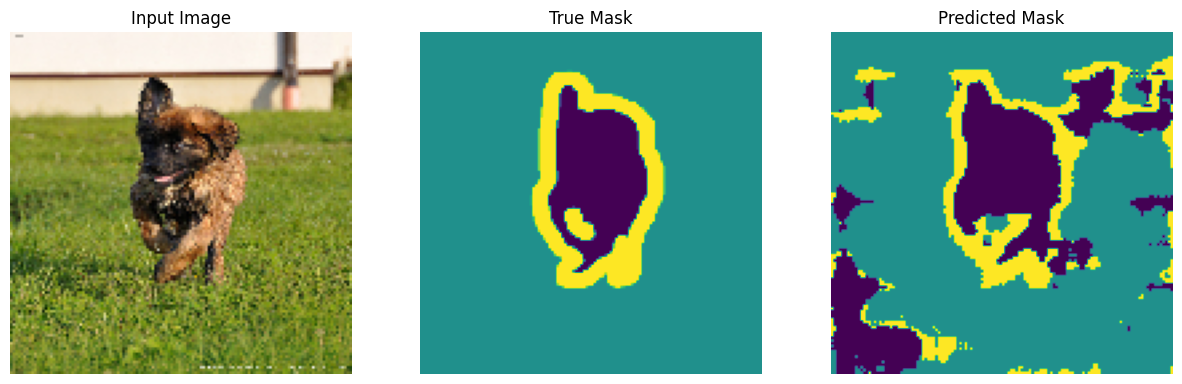

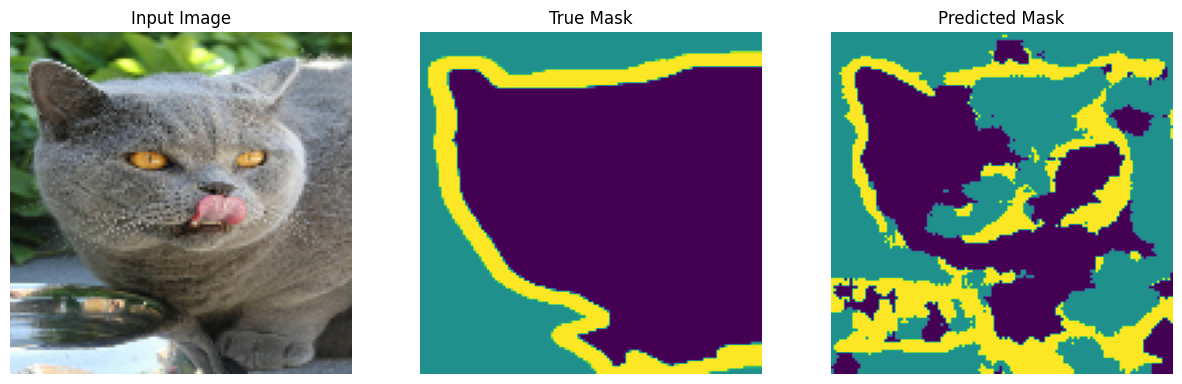

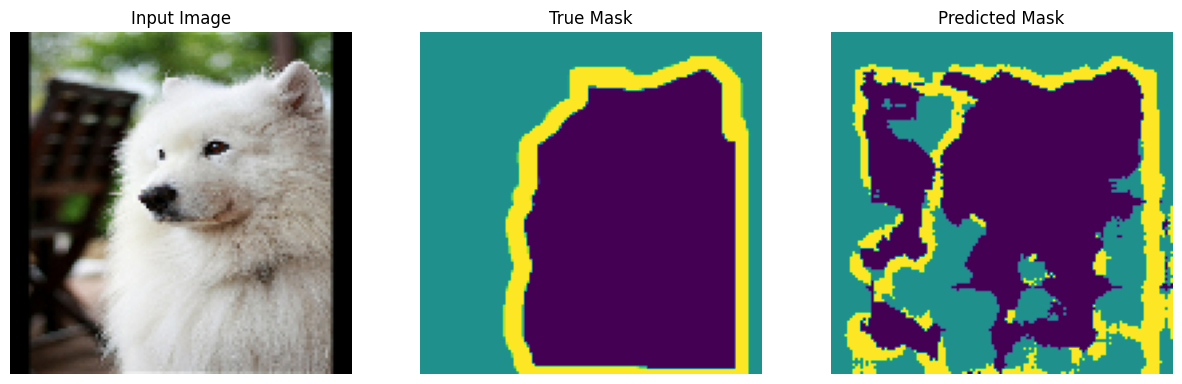

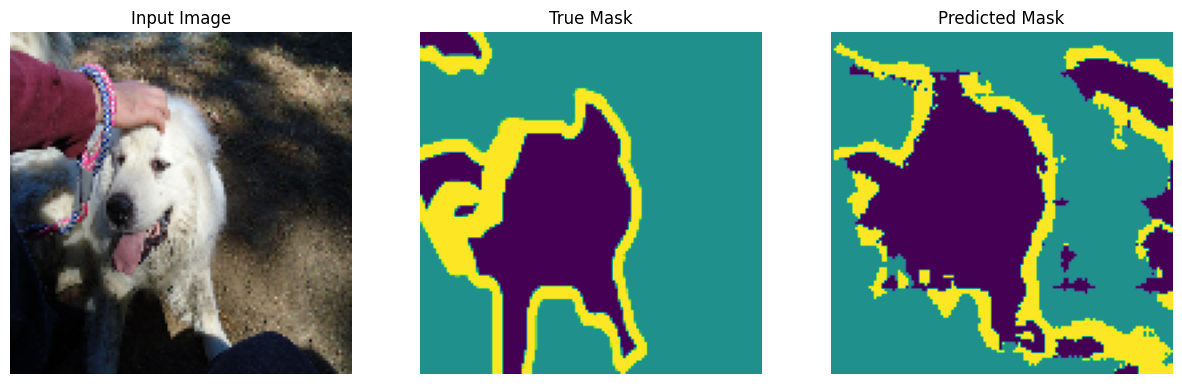

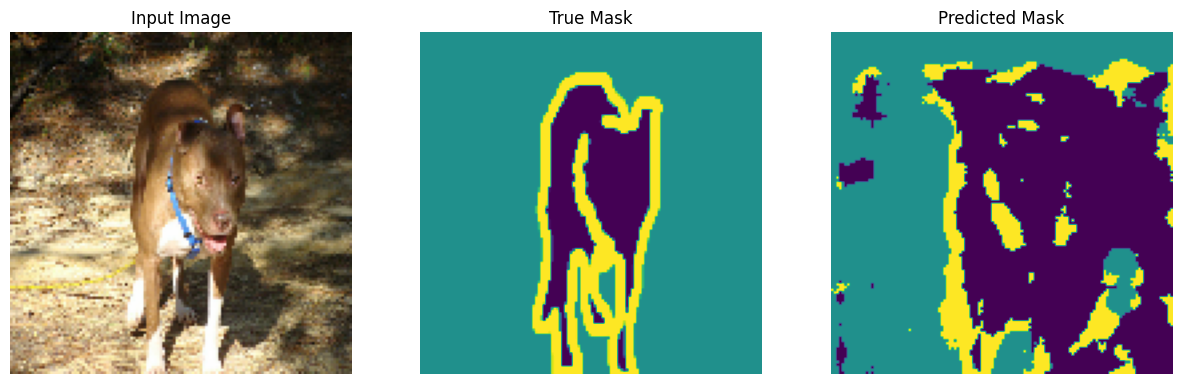

In [95]:
# 테스트 데이터 시각화
show_predictions(test_dataset, 5)